## IMPORTING LIBRARIES

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
%matplotlib inline

## IMPLEMENTATION OF MAIN ALGORITHM

In [29]:
 #loading test image

image_loc = './dataset/22_00007_00022.ppm'
sample_image = cv2.imread(image_loc)

#defining per channel CLAHE

def clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for c in range(2):
        img[:,:,c] = clahe.apply(img[:,:,c])
    return img

#converting RGB->Grayscale after applying CLAHE

gray_img = cv2.cvtColor(clahe(sample_image), cv2.COLOR_BGR2GRAY)

#thresholding grayscale image

lower_limit = gray_img.mean()
upper_limit = gray_img.max()
ret, gray_thresh = cv2.threshold(gray_img, lower_limit, upper_limit, cv2.THRESH_BINARY)

#applying Gaussian blur

gaussian_blur = cv2.GaussianBlur(gray_thresh, (3,3), 0)

#applying Canny edge detection

edge_image = cv2.Canny(gaussian_blur, 100, 200)

#extracting ROI

blank_image = np.zeros((sample_image.shape[0], sample_image.shape[1]))
image, contours, hierarchy = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img = cv2.drawContours(blank_image, contours, -1, 255, 1)

Area=[]
max_countour_area = -99999999
maxm_index = -1
for i in range(len(contours)):
    Area.append(cv2.contourArea(contours[i]))
    if Area[i]>max_countour_area:
        max_countour_area = Area[i]
        maxm_index = i
        
blank_image = np.zeros((sample_image.shape[0], sample_image.shape[1]))

cnt = contours[maxm_index]

img_with_detected_contour = cv2.drawContours(blank_image, cnt, -1, 255, 1)

img_with_detected_contour = cv2.fillPoly(img_with_detected_contour, pts =[cnt], color=(255,255,255))

x,y,w,h = cv2.boundingRect(cnt)

img_with_bounding_box = cv2.rectangle(img_with_detected_contour, (x,y), (x+w,y+h), 255, 1)

ROI_from_original_image = sample_image[y:y+h,x:x+w]

img_with_bounding_box = img_with_detected_contour[y:y+h,x:x+w]

img_with_bounding_box/=255.0

img_with_bounding_box=img_with_bounding_box.astype(np.uint8)

for i in range(3):
    ROI_from_original_image[:,:,i]*=img_with_bounding_box

In [30]:
#sampling 100 random points fro detected contour

rnd = random.sample(range(len(cnt)), 100)
rnd.sort()
cnt_sampled = []
for i in range(100):
    cnt_sampled.append(cnt[rnd[i]])
cnt_sampled = np.array(cnt_sampled)
blank_image = np.zeros((sample_image.shape[0], sample_image.shape[1]))
img_with_sampled_contour = cv2.drawContours(blank_image, cnt_sampled, -1, 255, 1)

In [31]:
#computing normalised signature of detected contour

M = cv2.moments(cnt_sampled)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
distance_array = []
max_distance_from_perimeter = -999999
for i in range(100):
    dist = ((cx-cnt_sampled[i][0][0])**2+(cy-cnt_sampled[i][0][1])**2)**0.5
    if dist>max_distance_from_perimeter:
        max_distance_from_perimeter = dist
    distance_array.append(dist)
for i in range(100): 
    distance_array[i] = distance_array[i]/max_distance_from_perimeter

In [32]:
#computing normalised signature of circle

def calc_signature_circle(*args, **kwargs):
    L_circ=[1 for i in range (100)]
    
    return L_circ

#computing normalised signature of square

def calc_signature_square(*args, **kwargs):
    xy=[]
    for i in range (26):
        xy.append([i,25])
    for i in range (1,26):
        xy.append([25,25-i])
    for i in range (1,26):
        xy.append([25-i,0])
    for i in range (1,25):
        xy.append([0,i])
    L_sq=[]
    max_sq=-1
    for i in range(100):
        dist=((12.5-xy[i][0])**2+(12.5-xy[i][1])**2)**0.5
        L_sq.append(dist)
        if max_sq<dist: 
            max_sq=dist
    for i in range(100): 
        L_sq[i]=L_sq[i]/max_sq
    
    return L_sq

#computing normalised signature of octagon

def calc_signature_octagon(*args, **kwargs):
    xy=[]
    for i in range (13):
        xy.append([i,13-i])
    for i in range (1,13):
        xy.append([13+(13*(2**0.5)*i/12),0])
    L_oct=[]
    max_oct=-1
    for i in range(25):
        dist=(((13+13/(2**0.5))-xy[i][0])**2+((13+13/(2**0.5))-xy[i][1])**2)**0.5
        L_oct.append(dist)
        if max_oct<dist: max_oct=dist
    for i in range(25): 
        L_oct[i]=L_oct[i]/max_oct
    for i in range (75): 
        L_oct.append(L_oct[i%25])
    
    return L_oct

#computing normalised signature of triangle
        
def calc_signature_triangle(*args, **kwargs):
    xy=[]
    for i in range (34):
        xy.append([(16/34)*i,(16/34)*i*(3**0.5)])
    xy.append([16,16*(3**0.5)])
    for i in range (34):
        xy.append([17+(16/34)*i,(16-(16/34)*i)*(3**0.5)])
    for i in range (31,0,-1):
        xy.append([i,0])
    L_tr=[]
    max_tr=-1
    for i in range(17,100):
        dist=((16-xy[i][0])**2+(9.2376-xy[i][1])**2)**0.5
        L_tr.append(dist)
        if max_tr<dist: max_tr=dist
    for i in range(17):
        dist=((16-xy[i][0])**2+(9.2376-xy[i][1])**2)**0.5
        L_tr.append(dist)
        if max_tr<dist: 
            max_tr=dist
    for i in range(100):
        L_tr[i]=L_tr[i]/max_tr
    
    return L_tr

In [33]:
def calc_signature(shape):
    if shape == 'circle':
        return calc_signature_circle()
    elif shape == 'square':
        return calc_signature_square()
    elif shape == 'triangle':
        return calc_signature_triangle()
    else:
        return calc_signature_octagon()

In [34]:
#calculating absolute difference between template signature and contour signature

template_shapes = ['circle', 'square', 'triangle', 'octagon']
diff = {'circle': 0, 'square': 0, 'triangle': 0, 'octagon': 0}
for j in range(len(template_shapes)):
    for i in range(100):
        diff[template_shapes[j]]+=abs(distance_array[i]-calc_signature(template_shapes[j])[i])
        
sorted_diff = sorted(diff.items(), key=lambda kv: kv[1])

most_probable_shape = sorted_diff[0][0]

second_most_probable_shape = sorted_diff[1][0]

In [35]:
#defining cross-correation coefficient

def calc_correlation_coefficient(template, test_img):
    template = cv2.resize(template,(test_img.shape[1], test_img.shape[0]))
    num=0
    den1=0
    den2=0
    for i in range(3):
        num1 = np.sum((test_img[:,:,i]-test_img[:,:,i].mean())*(template[:,:,i]-template[:,:,i].mean()))
        den01 = np.sum((test_img[:,:,i]-test_img[:,:,i].mean())**2)
        den02 = np.sum((template[:,:,i]-template[:,:,i].mean())**2)
        num+=num1
        den1+=den01
        den2+=den02
    num=num/3
    den1=den1/3
    den2=den2/3
    den = (den1*den2)**0.5
    R = num/den
    return R

In [36]:
#detecting traffic sign

template_folders_loc = './templates/'
max_R = -99999
for shape in os.listdir(template_folders_loc):
    if shape == most_probable_shape or shape == second_most_probable_shape:
        template_img_loc = template_folders_loc+str(shape)+'//'
        for img in os.listdir(template_img_loc):
            template_img = cv2.imread(template_img_loc+img)
            corr_coeff = calc_correlation_coefficient(template_img, ROI_from_original_image)
            if corr_coeff>max_R:
                max_R = corr_coeff
                traffic_sign = template_img

## VISUALISATION OF INTERMEDIATE RESULTS AND FINAL RESULT

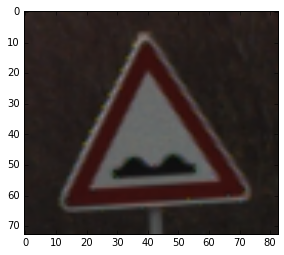

In [37]:
test_img = cv2.imread(image_loc)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

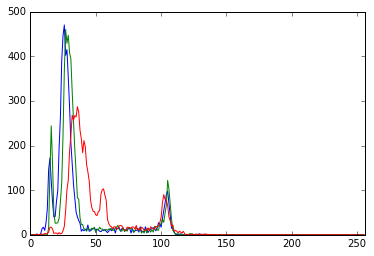

In [38]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([test_img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

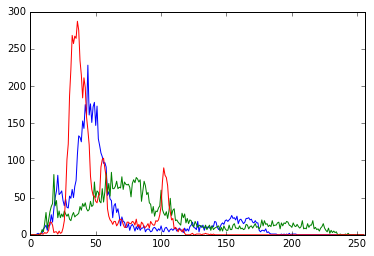

In [39]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([clahe(test_img)],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

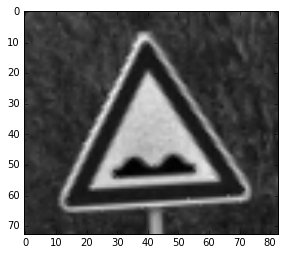

In [40]:
plt.imshow(gray_img, cmap = 'gray')
plt.show()

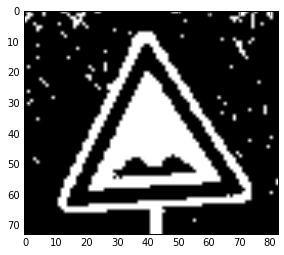

In [41]:
plt.imshow(gray_thresh, cmap = 'gray')
plt.show()

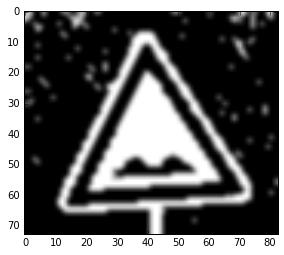

In [42]:
plt.imshow(gaussian_blur, cmap = 'gray')
plt.show()

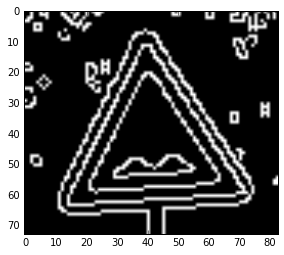

In [43]:
plt.imshow(edge_image, cmap = 'gray')
plt.show()

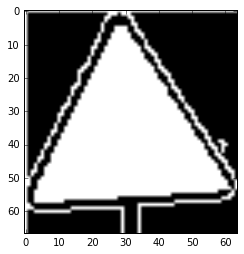

In [44]:
plt.imshow(img_with_bounding_box, cmap = 'gray')
plt.show()

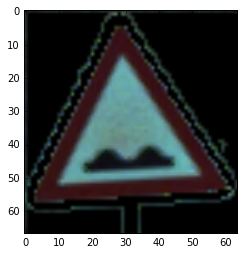

In [45]:
plt.imshow(cv2.cvtColor(ROI_from_original_image, cv2.COLOR_BGR2RGB))
plt.show()

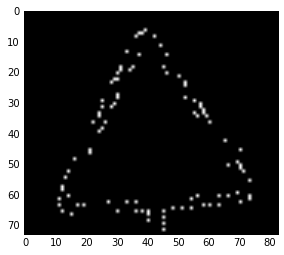

In [46]:
plt.imshow(img_with_sampled_contour, cmap='gray')
plt.show()

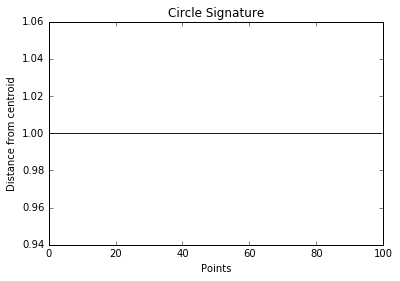

In [47]:
x = [i for i in range(100)] 
y = [calc_signature_circle()[i] for i in range(100)] 

plt.plot(x, y) 
  
plt.xlabel('Points') 
plt.ylabel('Distance from centroid') 
plt.title('Circle Signature') 
plt.show()

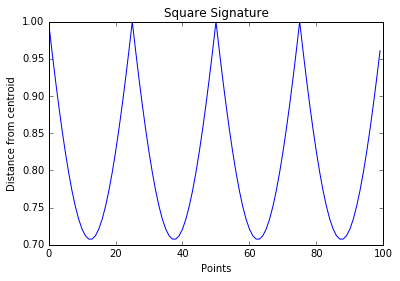

In [48]:
x = [i for i in range(100)] 
y = [calc_signature_square()[i] for i in range(100)] 

plt.plot(x, y) 
  
plt.xlabel('Points') 
plt.ylabel('Distance from centroid') 
plt.title('Square Signature') 
plt.show() 

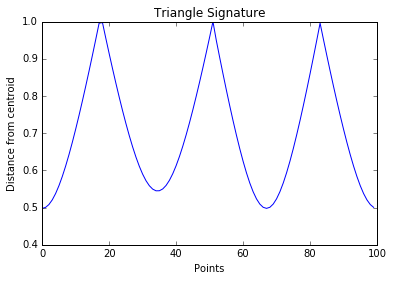

In [49]:
x = [i for i in range(100)] 
y = [calc_signature_triangle()[i] for i in range(100)] 

plt.plot(x, y) 
  
plt.xlabel('Points') 
plt.ylabel('Distance from centroid') 
plt.title('Triangle Signature') 
plt.show()

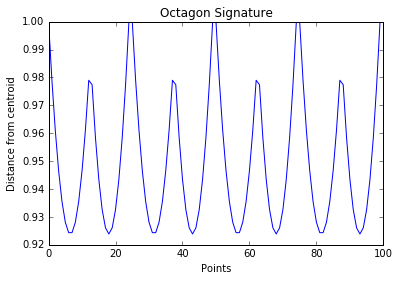

In [50]:
x = [i for i in range(100)] 
y = [calc_signature_octagon()[i] for i in range(100)] 

plt.plot(x, y) 
  
plt.xlabel('Points') 
plt.ylabel('Distance from centroid') 
plt.title('Octagon Signature') 
plt.show()

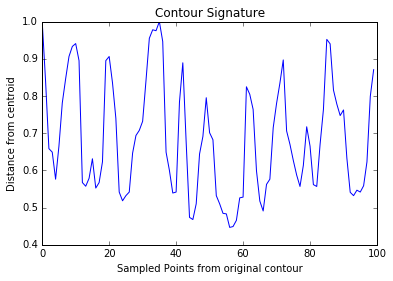

In [51]:
x = [i for i in range(100)] 
y = [distance_array[i] for i in range(100)] 

plt.plot(x, y) 
  
plt.xlabel('Sampled Points from original contour') 
plt.ylabel('Distance from centroid') 
axes = plt.gca()
plt.title('Contour Signature') 
plt.show()

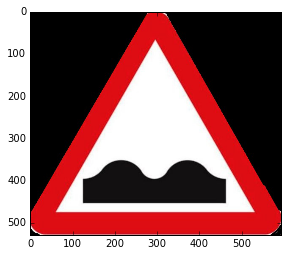

In [52]:
plt.imshow(cv2.cvtColor(traffic_sign, cv2.COLOR_BGR2RGB))
plt.show()